<a href="https://colab.research.google.com/github/sahilhomeground/mediapipe/blob/main/MediaPipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe
!pip install imageio

     |████████████████████████████████| 34.0 MB 50 kB/s 


In [7]:
import math
import cv2
import numpy as np
import os
import io
from time import time
import json

import imageio
import PIL
from IPython.display import Image,display
import mediapipe as mp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.cm as cm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose
 
# Setting up the Pose function.
pose = mp_pose.Pose(model_complexity=2)
 
# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

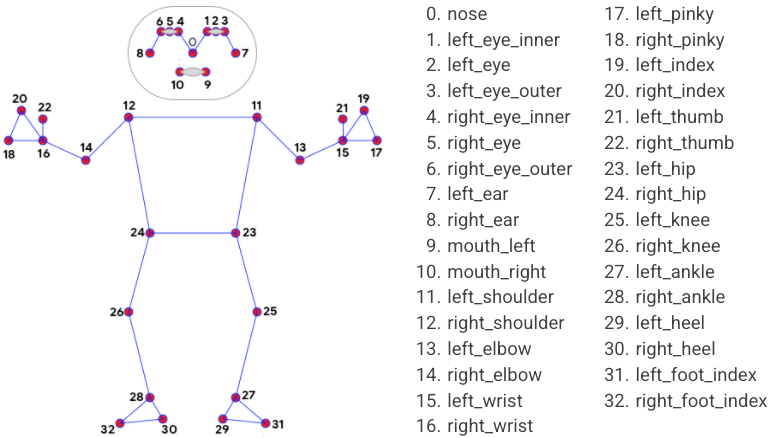

In [4]:
Image("https://i.imgur.com/3j8BPdc.png")

In [5]:
def plotLin(i1,i2,landmarks,ax):
  p1 = landmarks[i1]
  p2 = landmarks[i2]
  ax.plot([p1[0],p2[0]],[p1[1],p2[1]],[p1[2],p2[2]],color="orange")


# join input frame and inference
def compileOutput(inframe,outframe,ih):
  #print(np.shape(inframe))
  #print(np.shape(outframe))
  output_height = np.shape(outframe)[1]
  output_width = np.shape(outframe)[0]
  scaleFactor = ih/output_height
  scaled_width = int(output_width * scaleFactor)
  scaled_output = cv2.resize(outframe, (scaled_width, ih))

  final_output = np.concatenate((inframe,scaled_output),axis=1)
  return final_output

def getMinMaxxyz(landmarks):
  #initialise min max xyz as midpoints of the hip
  hip = landmarks[24]
  min_xyz = [hip[0],hip[1],hip[2]]
  max_xyz = [hip[0],hip[1],hip[2]]
  arr_tuples = []
  for landmark in landmarks:
    xs = landmark[0]
    ys = landmark[1]
    zs = landmark[2]
    temp_xyz = [xs,ys,xs]
    min_xyz = [min(a,b) for (a,b) in zip(min_xyz,temp_xyz)]
    max_xyz = [max(a,b) for (a,b) in zip(max_xyz,temp_xyz)]
    arr_tuples.append([xs,ys,zs])
  return [min_xyz,max_xyz,arr_tuples]

In [6]:
def get3Dinference(landmarks,min_xyz,max_xyz):
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.view_init(-85, -90)
  plt.tick_params(axis='both', labelsize=0, length = 0)

  plotLin(11,12,landmarks,ax)
  plotLin(11,23,landmarks,ax)
  plotLin(12,24,landmarks,ax)
  plotLin(23,24,landmarks,ax)
  plotLin(11,13,landmarks,ax)
  plotLin(13,15,landmarks,ax)
  plotLin(14,12,landmarks,ax)
  plotLin(14,16,landmarks,ax)
  plotLin(24,26,landmarks,ax)
  plotLin(23,25,landmarks,ax)
  plotLin(26,28,landmarks,ax)
  plotLin(25,27,landmarks,ax)
  plotLin(0,11,landmarks,ax)
  plotLin(0,12,landmarks,ax)
  plotLin(0,2,landmarks,ax)
  plotLin(0,5,landmarks,ax)
  plotLin(7,2,landmarks,ax)
  plotLin(8,5,landmarks,ax)
  #ax.plot([-100,100],[-100,100],[-100,100])

  boundary_points = []
  range_xyz = [(b-a) for (a,b) in zip(min_xyz,max_xyz)]
  max_range = int(max(range_xyz)/2)
  mid_xyz = [int((b+a)/2) for (a,b) in zip(min_xyz,max_xyz)]
  #print(max_xyz)
  #print(min_xyz)
  #print(mid_xyz)
  x_mid, y_mid, z_mid = mid_xyz

  for xs in [-max_range,max_range]:
    for ys in [-max_range,max_range]:
      for zs in [-max_range,max_range]:
        ax.scatter3D(x_mid + xs,y_mid + ys,z_mid + zs)


  ax.set_zlabel("Z axis")
  plt.xlabel("X axis")
  plt.ylabel("Y axis")
  #plt.axis('off')

  buf = io.BytesIO()
  fig.savefig(buf)
  buf.seek(0)
  return PIL.Image.open(buf)

In [9]:
INPUT_DIR = 'drive/My Drive/MediaPipe Videos'
OUTPUT_DIR = 'drive/My Drive/MediaPipe Outputs'

filename = os.listdir(INPUT_DIR)[0]
VID_PATH = os.path.join(INPUT_DIR,filename)
video = cv2.VideoCapture(VID_PATH)

iiw = int(video.get(3))
iih = int(video.get(4))
outputs = []
frame_counter = 0

global_landmarks = []

# Iterate until the video is accessed successfully.
while video.isOpened():
    
    # Read a frame.
    ret, frame = video.read()
    
    # Check if frame is not read properly.
    if (frame is None):
        # create output
        new_file  = os.path.join(OUTPUT_DIR, filename)
        nprgb_outputs = np.array(outputs)
        nwidth = np.shape(nprgb_outputs)[2]
        nheight = np.shape(nprgb_outputs)[1]
        #print(nwidth,nheight)
        out = cv2.VideoWriter(new_file,cv2.VideoWriter_fourcc(*'MJPG'), 30, (nwidth,nheight))
        for frame_f in nprgb_outputs:
          out.write(frame_f)
        out.release()
        #with imageio.get_writer(new_file, mode='I') as writer:
        #  for frame_f in outputs:
        #    writer.append_data(frame_f)
        #imageio.mimsave(new_file,nprgb_outputs)
        print("Total " + str(frame_counter) + " frames counted. Compiling Output...")
        print("....")
        json_data = {
            'landmarks': global_landmarks
        }
        array_file = os.path.join(OUTPUT_DIR, filename[:-4 ] + "_array.json")
        with open(array_file, "w") as json_file:
          json.dump(json_data, json_file)
        print(global_landmarks)
        break

    frame_counter += 1
    print("Processing Frame " + str(frame_counter))
    
    # Recolor image to RGB
    image = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    results = pose.process(image)
    height, width, _ = image.shape

    # Recolor back to BGR
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Render detections
    landmarks = []
    #mp_drawing.plot_landmarks(results.pose_world_landmarks,mp_pose.POSE_CONNECTIONS)
    #print(results)
    if (results.pose_landmarks):
      print("Landmarks Detected")
      for landmark in results.pose_landmarks.landmark:
        landmarks.append((int(landmark.x * width), int(landmark.y * height), int(landmark.z * width)))
      min_xyz, max_xyz, landmark_tuples = getMinMaxxyz(landmarks)
      #print(min_xyz,max_xyz)
      output = get3Dinference(landmarks,min_xyz,max_xyz)
      np_output = np.array(output)
      rgb_output = []
      for row in range(len(np_output)):
        output_row = []
        for col in range(len(np_output[row])):
          output_col = []
          pixel = np_output[row][col]
          np_pixel = np.array([pixel[0],pixel[1],pixel[2]])
          output_row.append(np_pixel)
        np_row = np.array(output_row)
        rgb_output.append(np_row)
      nprgb_output = np.array(rgb_output)
      plt.close()
      compilation = compileOutput(image,nprgb_output,iih)
      outputs.append(compilation)
      global_landmarks.append(landmark_tuples)
      #print(np.shape(nprgb_output))
      #print(global_landmarks)
      #plt.imshow(nprgb_output)
      #plt.show()



    #outputs.append(mp_drawing)
 
# Release the VideoCapture object.
video.release()

Processing Frame 1
Landmarks Detected
Processing Frame 2
Landmarks Detected
Processing Frame 3
Landmarks Detected
Processing Frame 4
Landmarks Detected
Processing Frame 5
Landmarks Detected
Processing Frame 6
Landmarks Detected
Processing Frame 7
Landmarks Detected
Processing Frame 8
Landmarks Detected
Processing Frame 9
Landmarks Detected
Processing Frame 10
Landmarks Detected
Processing Frame 11
Landmarks Detected
Processing Frame 12
Landmarks Detected
Processing Frame 13
Landmarks Detected
Processing Frame 14
Landmarks Detected
Processing Frame 15
Landmarks Detected
Processing Frame 16
Landmarks Detected
Processing Frame 17
Landmarks Detected
Processing Frame 18
Landmarks Detected
Processing Frame 19
Landmarks Detected
Processing Frame 20
Landmarks Detected
Processing Frame 21
Landmarks Detected
Processing Frame 22
Landmarks Detected
Processing Frame 23
Landmarks Detected
Processing Frame 24
Landmarks Detected
Processing Frame 25
Landmarks Detected
Processing Frame 26
Landmarks Dete